In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os 
import re
import string
from math import*
import jellyfish
import gensim
from os import path


In [2]:
from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [3]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import distance
from bs4 import BeautifulSoup
nltk.download('stopwords')
nltk.download('universal_tagset')

from vocabulary.vocabulary import Vocabulary
import utils
from string import punctuation
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sinch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sinch\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
from textblob import TextBlob
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\sinch\\Anaconda3\\lib\\site-packages\\utils\\__init__.py'>

In [5]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [6]:
df=pd.read_csv('D:/Stats&ML/quora-question-pairs/train.csv', sep=',',header=0)

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


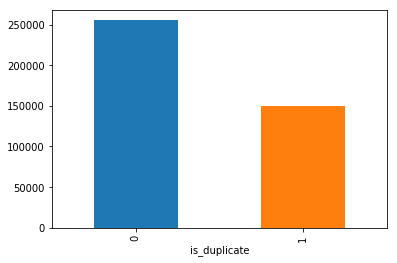

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Number of occurrences of each question

Maximum number of times a single question is repeated: 157



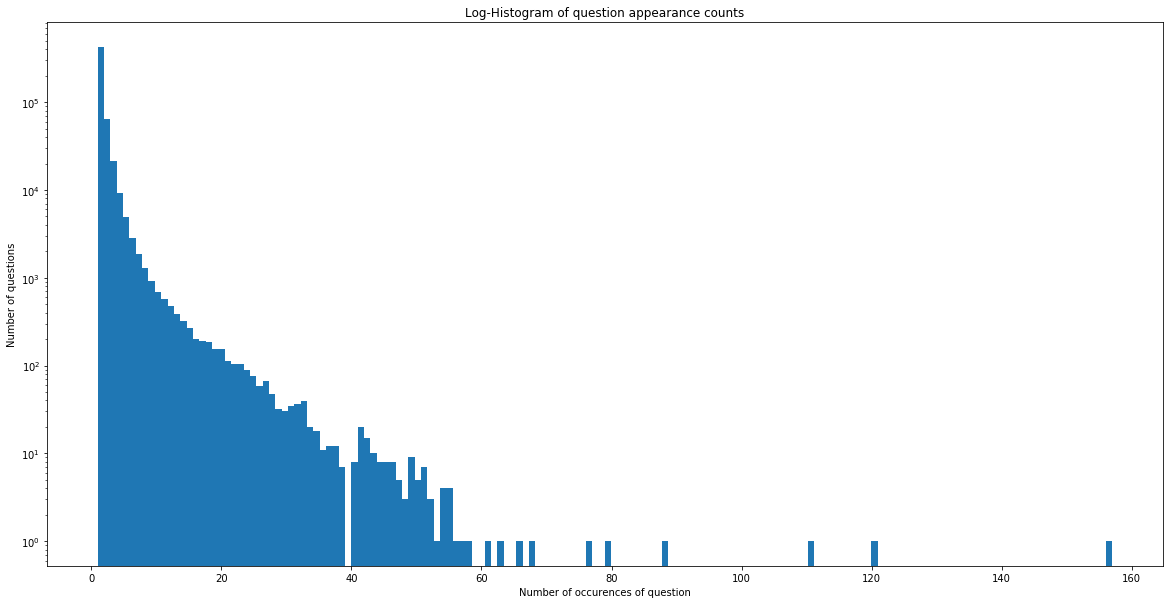

In [10]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [11]:
df.dropna(inplace=True)

In [12]:
df['question1'].dtype

dtype('O')

In [13]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
#df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
#df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df['q1_n_words']=df['question1'].astype(str).str.split()
df['q2_n_words']=df['question2'].astype(str).str.split()
#def normalized_word_Common(row):
 #   w1 = set(map(lambda word: word.lower().strip(), row['question1'].astype(str).str.split()))
  #w2 = set(map(lambda word: word.lower().strip(), row['question2'].astype(str).str.split()))    
   # return 1.0 * len(w1 & w2)
#df['word_Common'] = df.apply(normalized_word_Common, axis=1)

#def normalized_word_Total(row):
#   w1 = set(map(lambda word: word.lower().strip(), row['question1'].astype(str).str.split()))
#   w2 = set(map(lambda word: word.lower().strip(), row['question2'].astype(str).str.split()))    
#   return 1.0 * (len(w1) + len(w2))
#df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

#    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,"[What, is, the, story, of, Kohinoor, (Koh-i-No...","[What, would, happen, if, the, Indian, governm...",0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,...",0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,"[Why, am, I, mentally, very, lonely?, How, can...","[Find, the, remainder, when, [math]23^{24}[/ma...",0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water?]",0.100000,4,2


C:\Users\sinch\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


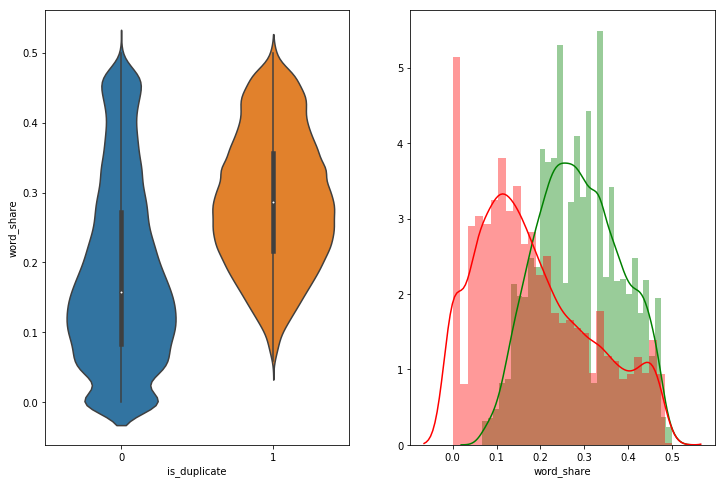

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

C:\Users\sinch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\sinch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\sinch\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


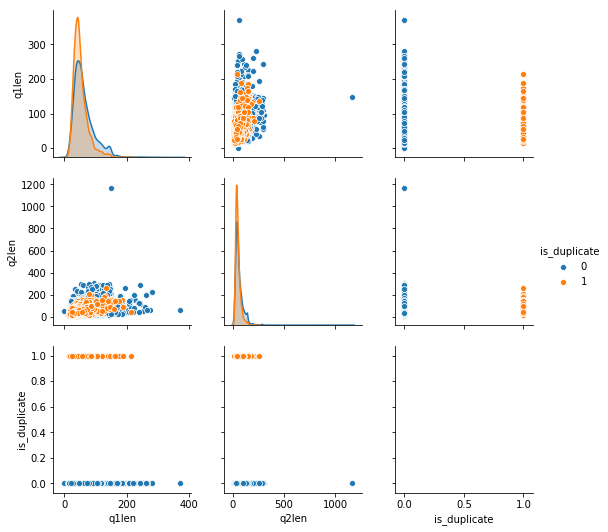

In [15]:
n = 10000
sns.pairplot(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate']][0:n], hue='is_duplicate')

In [16]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_share, freq_q1+q2, freq_q1-q2]
Index: []


In [17]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_share, freq_q1+q2, freq_q1-q2]
Index: []


# Cleaning Text :

* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [18]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [19]:
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

In [20]:
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

C:\Users\sinch\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [21]:
print("Extracting NLP features for train:")
df = extract_features(df)
df.head(2)

Extracting NLP features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# Analysis of extracted features 
* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [22]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

np.savetxt('D:/Stats&ML/quora-question-pairs/train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('D:/Stats&ML/quora-question-pairs/train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


In [23]:
p[94:104]

array(['why does red keep the keys in oitnb ',
       'why does red keep the keys in season 4 of orange is the new black ',
       'if i do not monetize youtube videos   upload copyright content  then are there chances that google may block my account ',
       'how do you upload movies on youtube and monetize them  is there any issue of copyright',
       'what does the quora website look like to members of quora moderation ',
       'how does quora look to a moderator ',
       'why nobody answer my questions in quora ',
       'why is no one answering my questions in quora ',
       'what is the funniest joke you know ',
       'what is the funniest joke of all time '], dtype=object)

In [24]:
# removing the Stop Words:
d = path.dirname('D:/Stats&ML/quora-question-pairs/')
textp_w = open(path.join(d, 'D:/Stats&ML/quora-question-pairs/train_p.txt'),encoding='utf8').read()
textn_w = open(path.join(d, 'D:/Stats&ML/quora-question-pairs/train_n.txt'),encoding='utf8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33192876


In [25]:
p

array(['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me ',
       'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ',
       'how can i be a good geologist ', ...,
       'what does jainism say about gays and homosexuality ',
       'do you believe there is life after death ',
       'is it true that there is life after death '], dtype=object)

# Word Clouds generated from duplicate pair question's text 

Word Cloud for Duplicate Question pairs


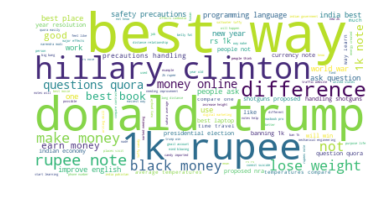

In [26]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
#textp_w=p.astype(str).str.cat(sep=' ')
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word Clouds generated from non duplicate pair question's text 

Word Cloud for non-Duplicate Question pairs:


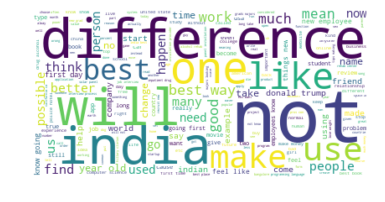

In [27]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Featurizing text data with tfidf weighted word-vectors

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
df_new = pd.read_csv("D:/Stats&ML/quora-question-pairs/train.csv")

In [3]:
df = pd.read_csv("D:/Stats&ML/quora-question-pairs/nlp_features_train.csv")

In [19]:
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df_new['question1'] = df_new['question1'].apply(lambda x: str(x))
df_new['question2'] = df_new['question2'].apply(lambda x: str(x))

In [3]:
df_new.dropna(inplace=True)

In [5]:
nan_rows = df_new[df_new.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, q1_feats_m, q2_feats_m]
Index: []


In [6]:
df_new = df_new.fillna('')
nan_rows = df_new[df_new.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, q1_feats_m, q2_feats_m]
Index: []


In [4]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2  \
3306      3306    6553    6554   
13016    13016   25026   25027   
20072    20072   37898   37899   
20794    20794   39204   39205   
47056    47056   84067   84068   
96725    96725  161071  161072   
104101  104101  171925  171926   
134402  134403  214814  214815   
189658  189659  161071  288480   
190569  190570  289688  289689   
208483  208485  312495  312496   
213218  213220   25026   64784   
226923  226925  335645  335646   
254159  254161  214814  368834   
273063  273065  391451  380455   
301581  301583  424494  424495   
384290  384293  516316   37899   
402420  402423  535899  119568   

                                                question1  \
3306                                                  NaN   
13016                                                 NaN   
20072                             how could i solve this    
20794                                                 NaN   
47056   is there anywhere in the world offering 

In [5]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

* After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
* here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
* It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [21]:
import en_core_web_sm

In [22]:
nlp = en_core_web_sm.load()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list(df.question1)): # for each review/sentence
    doc2 = nlp(sent) 
    #sent_vec = np.zeros([len(sent),96]) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in doc2: # for each word in a review/sentence
        try:
            vec = word.vector
           # print(vec)
            sent_vec = np.zeros(len(vec))
           # print(sent_vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = word2tfidf[str(word)]
           # print(tfidf)
            
        except:
            tfidf=0
          #  print(tfidf)
            
        sent_vec+=(vec*tfidf)
       # print('sent_vec1: ',sent_vec)
        weight_sum+=tfidf
        # print('weight_sum: ',weight_sum)
    sent_vec/=weight_sum
    #sent_vec=np.sum(sent_vec)
    #print('sent_vec2: ',sent_vec)

    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
df_new['q1_feats_m'] = list(tfidf_sent_vectors)

100%|███████████████████████████████████████████████████████████████████████| 404287/404287 [1:05:34<00:00, 102.76it/s]


In [ ]:
df_new.to_csv("D:/Stats&ML/quora-question-pairs/df_new_fe_without_preprocessing_train.csv", index=False)

In [23]:
tfidf_sent_vectors = [];# the tfidf-w2v for each sentence/review is stored in this list
nlp = en_core_web_sm.load()
row=0;
for sent in tqdm(list(df.question2)): # for each review/sentence
    doc2 = nlp(sent) 
    #sent_vec = np.zeros([len(sent),96]) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in doc2: # for each word in a review/sentence
        try:
            vec = word.vector
           # print(vec)
            sent_vec = np.zeros(len(vec))
           # print(sent_vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = word2tfidf[str(word)]
           # print(tfidf)
            
        except:
            tfidf=0
          #  print(tfidf)
            
        sent_vec+=(vec*tfidf)
       # print('sent_vec1: ',sent_vec)
        weight_sum+=tfidf
        # print('weight_sum: ',weight_sum)
    sent_vec/=weight_sum
    #sent_vec=np.sum(sent_vec)
    #print('sent_vec2: ',sent_vec)

    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
df_new['q2_feats_m'] = list(tfidf_sent_vectors)

100%|█████████████████████████████████████████████████████████████████████████| 404287/404287 [47:48<00:00, 140.94it/s]


In [24]:
df_new.to_csv("D:/Stats&ML/quora-question-pairs/df_new_fe_without_preprocessing_train.csv", index=False)

In [25]:
df_new.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[0.3730830598447339, -0.07306187215982796, -0....","[0.5469119918840772, -0.4160353681032705, 0.25..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[0.41154249835816886, -0.2773741492263761, -0....","[-0.02048526990550423, -0.13671610380465163, -..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[0.21518253288158082, -0.4668795966664348, -0....","[0.3621317271047846, -0.2617275131207381, -0.3..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[-0.036292865530617474, -0.054723714766688365,...","[0.4330107178941369, -0.0815043040032801, -0.4..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[0.2683216622299938, -0.29576037559880985, -0....","[0.323178618515447, -0.6747699296032229, 0.395..."


In [30]:
dfppro = pd.read_csv("D:/Stats&ML/quora-question-pairs/df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [31]:
df1 = df.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df_new.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [32]:
df3_1 = pd.DataFrame(df_new.q1_feats_m.values.tolist(), index= df_new.index)

In [33]:
df3_2 = pd.DataFrame(df_new.q2_feats_m.values.tolist(), index= df_new.index)

In [34]:
df1.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_share,freq_q1+q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,1,66,57,"['What', 'is', 'the', 'step', 'by', 'step', 'g...","['What', 'is', 'the', 'step', 'by', 'step', 'g...",0.434783,2,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,4,1,51,88,"['What', 'is', 'the', 'story', 'of', 'Kohinoor...","['What', 'would', 'happen', 'if', 'the', 'Indi...",0.200000,5,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,1,1,73,59,"['How', 'can', 'I', 'increase', 'the', 'speed'...","['How', 'can', 'Internet', 'speed', 'be', 'inc...",0.166667,2,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,1,1,50,65,"['Why', 'am', 'I', 'mentally', 'very', 'lonely...","['Find', 'the', 'remainder', 'when', '[math]23...",0.000000,2,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,3,1,76,39,"['Which', 'one', 'dissolve', 'in', 'water', 'q...","['Which', 'fish', 'would', 'survive', 'in', 's...",0.100000,4,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [35]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_share,freq_q1+q2,freq_q1-q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,1,66,57,"['What', 'is', 'the', 'step', 'by', 'step', 'g...","['What', 'is', 'the', 'step', 'by', 'step', 'g...",0.434783,2,0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,4,1,51,88,"['What', 'is', 'the', 'story', 'of', 'Kohinoor...","['What', 'would', 'happen', 'if', 'the', 'Indi...",0.200000,5,3,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,1,1,73,59,"['How', 'can', 'I', 'increase', 'the', 'speed'...","['How', 'can', 'Internet', 'speed', 'be', 'inc...",0.166667,2,0,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,1,1,50,65,"['Why', 'am', 'I', 'mentally', 'very', 'lonely...","['Find', 'the', 'remainder', 'when', '[math]23...",0.000000,2,0,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,3,1,76,39,"['Which', 'one', 'dissolve', 'in', 'water', 'q...","['Which', 'fish', 'would', 'survive', 'in', 's...",0.100000,4,2,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [37]:
df3_1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.373083,-0.073062,-0.132026,-0.042935,0.062092,-0.121409,0.201530,-0.031265,-0.266869,0.167448,...,0.114043,0.170178,0.207989,-0.146883,-0.013701,0.135615,0.057686,-0.061328,-0.198344,0.140304
1,0.411542,-0.277374,-0.003485,-0.009832,-0.288358,-0.555090,-0.151626,-0.349546,-0.298639,0.173740,...,0.298992,-0.082486,0.673565,0.004533,-0.002489,-0.622222,-0.341535,0.147179,-0.362315,-0.150651
2,0.215183,-0.466880,-0.314709,-0.389434,-0.112703,-0.090194,1.116247,-0.154850,0.337597,0.395591,...,0.543055,-0.149257,-0.023697,0.050879,-0.282785,0.007558,-0.253351,-0.388364,-0.496155,0.518584
3,-0.036293,-0.054724,0.177397,-0.071000,-0.171072,0.052482,-0.009882,0.009291,-0.168723,0.603510,...,-0.080837,-0.012996,-0.137067,0.019192,-0.199292,0.264524,0.195370,-0.123416,-0.121525,-0.008172
4,0.268322,-0.295760,-0.022798,-0.574495,-0.139599,0.017212,0.015533,-0.195810,-0.304087,0.232585,...,0.193761,-0.279774,0.329727,0.266755,0.159606,0.147507,-0.102908,0.241910,0.175180,-0.258506


In [38]:
df3_2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.546912,-0.416035,0.254160,-0.061077,-0.228911,0.232291,0.057154,-0.240027,-0.250279,0.406097,...,-0.007711,-0.211688,0.418038,-0.469761,0.121139,-0.177316,0.209025,-0.285857,-0.377817,0.689402
1,-0.020485,-0.136716,-0.251936,-0.402956,0.097809,-0.157754,0.077395,-0.215622,-0.092005,0.217757,...,0.048905,-0.106721,-0.087456,0.540074,0.057485,0.155638,-0.061117,0.114628,0.151169,-0.018621
2,0.362132,-0.261728,-0.388827,-0.836653,-0.171429,0.088909,0.254705,-0.379999,0.331378,0.420154,...,0.226636,-0.109853,-0.028152,0.248313,0.080669,0.422707,0.654455,0.143033,0.068402,-0.248437
3,0.433011,-0.081504,-0.413451,-0.033790,0.050922,0.558785,-0.128779,0.539383,-0.108410,0.554143,...,-0.045801,-0.025937,0.072673,-0.315981,0.011530,-0.172984,0.377890,-0.311705,-0.049273,-0.011067
4,0.323179,-0.674770,0.395382,-0.086710,-0.499551,-0.161685,0.361312,-0.248263,-0.397700,0.400564,...,-0.136832,-0.743436,0.677039,-0.550221,0.073783,-0.135713,0.242017,-0.226520,-0.350575,0.233260


In [39]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_1.shape[1]+df3_2.shape[1])

Number of features in nlp dataframe : 26
Number of features in preprocessed dataframe : 25
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 243


In [40]:
df3_1['id']=df1['id']
df3_2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_1.merge(df3_2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('D:/Stats&ML/quora-question-pairs/final_features.csv')

In [41]:
result.head()

,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_share_x,freq_q1+q2_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,1,1,66,57,"['What', 'is', 'the', 'step', 'by', 'step', 'g...","['What', 'is', 'the', 'step', 'by', 'step', 'g...",0.434783,2,...,-0.007711,-0.211688,0.418038,-0.469761,0.121139,-0.177316,0.209025,-0.285857,-0.377817,0.689402
1,1,0,4,1,51,88,"['What', 'is', 'the', 'story', 'of', 'Kohinoor...","['What', 'would', 'happen', 'if', 'the', 'Indi...",0.200000,5,...,0.048905,-0.106721,-0.087456,0.540074,0.057485,0.155638,-0.061117,0.114628,0.151169,-0.018621
2,2,0,1,1,73,59,"['How', 'can', 'I', 'increase', 'the', 'speed'...","['How', 'can', 'Internet', 'speed', 'be', 'inc...",0.166667,2,...,0.226636,-0.109853,-0.028152,0.248313,0.080669,0.422707,0.654455,0.143033,0.068402,-0.248437
3,3,0,1,1,50,65,"['Why', 'am', 'I', 'mentally', 'very', 'lonely...","['Find', 'the', 'remainder', 'when', '[math]23...",0.000000,2,...,-0.045801,-0.025937,0.072673,-0.315981,0.011530,-0.172984,0.377890,-0.311705,-0.049273,-0.011067
4,4,0,3,1,76,39,"['Which', 'one', 'dissolve', 'in', 'water', 'q...","['Which', 'fish', 'would', 'survive', 'in', 's...",0.100000,4,...,-0.136832,-0.743436,0.677039,-0.550221,0.073783,-0.135713,0.242017,-0.226520,-0.350575,0.233260
